# Principal Customers Network

_UNDER CONSTRUCTION_


- Graphs: ego network, induced subgraph
- Supply chain: principal customers

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from pandas.api import types
import numpy.ma as ma
from numpy.ma import masked_invalid as valid
from finds.database import SQL
from finds.graph import graph_info, graph_draw, nodes_centrality
from finds.misc import Show
from secret import paths, credentials
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)
sql = SQL(**credentials['sql'], verbose=VERBOSE)
imgdir = paths['images'] / 'supplychain'

In [2]:
# Retrieve principal customers info
year = 2016
cust = sql.read_dataframe(f"select gvkey, cgvkey, stic, ctic, conm, cconm "
                          f"  from customer "
                          f"    where srcdate >= {year}0101 "
                          f"      and srcdate <= {year}1231")

In [3]:
# To lookup company full name from ticker
lookup = pd.concat([Series(cust['conm'].values, cust['stic'].values),
                    Series(cust['cconm'].values, cust['ctic'].values)])\
           .drop_duplicates()

In [4]:
# Construct Directed Graph
vertices = set(cust['stic']).union(cust['ctic'])
edges = cust[['stic', 'ctic']].values.tolist()  # supplier --> customer

G = nx.DiGraph()
G.add_nodes_from(vertices)
G.add_edges_from(edges)

1. Show graph properties

In [5]:
graph_info(G)

{'triad_003': 1014214260,
 'triad_012': 5493913,
 'triad_102': 1826,
 'triad_021D': 7858,
 'triad_021U': 21706,
 'triad_021C': 1036,
 'triad_111D': 0,
 'triad_111U': 2,
 'triad_030T': 59,
 'triad_030C': 0,
 'triad_201': 0,
 'triad_120D': 0,
 'triad_120U': 0,
 'triad_120C': 0,
 'triad_210': 0,
 'triad_300': 0,
 'transitivity': 0.0037252178305341582,
 'average_clustering': 0.004935791976903955,
 'weakly_connected': False,
 'weakly_connected_components': 89,
 'size_largest_weak_component': 1628,
 'strongly_connected': False,
 'strongly_connected_components': 1829,
 'size_largest_strong_component': 2,
 'directed': True,
 'weighted': False,
 'edges': 3052,
 'nodes': 1830,
 'selfloops': 11,
 'density': 0.0009118422978903937}

2. Display graph

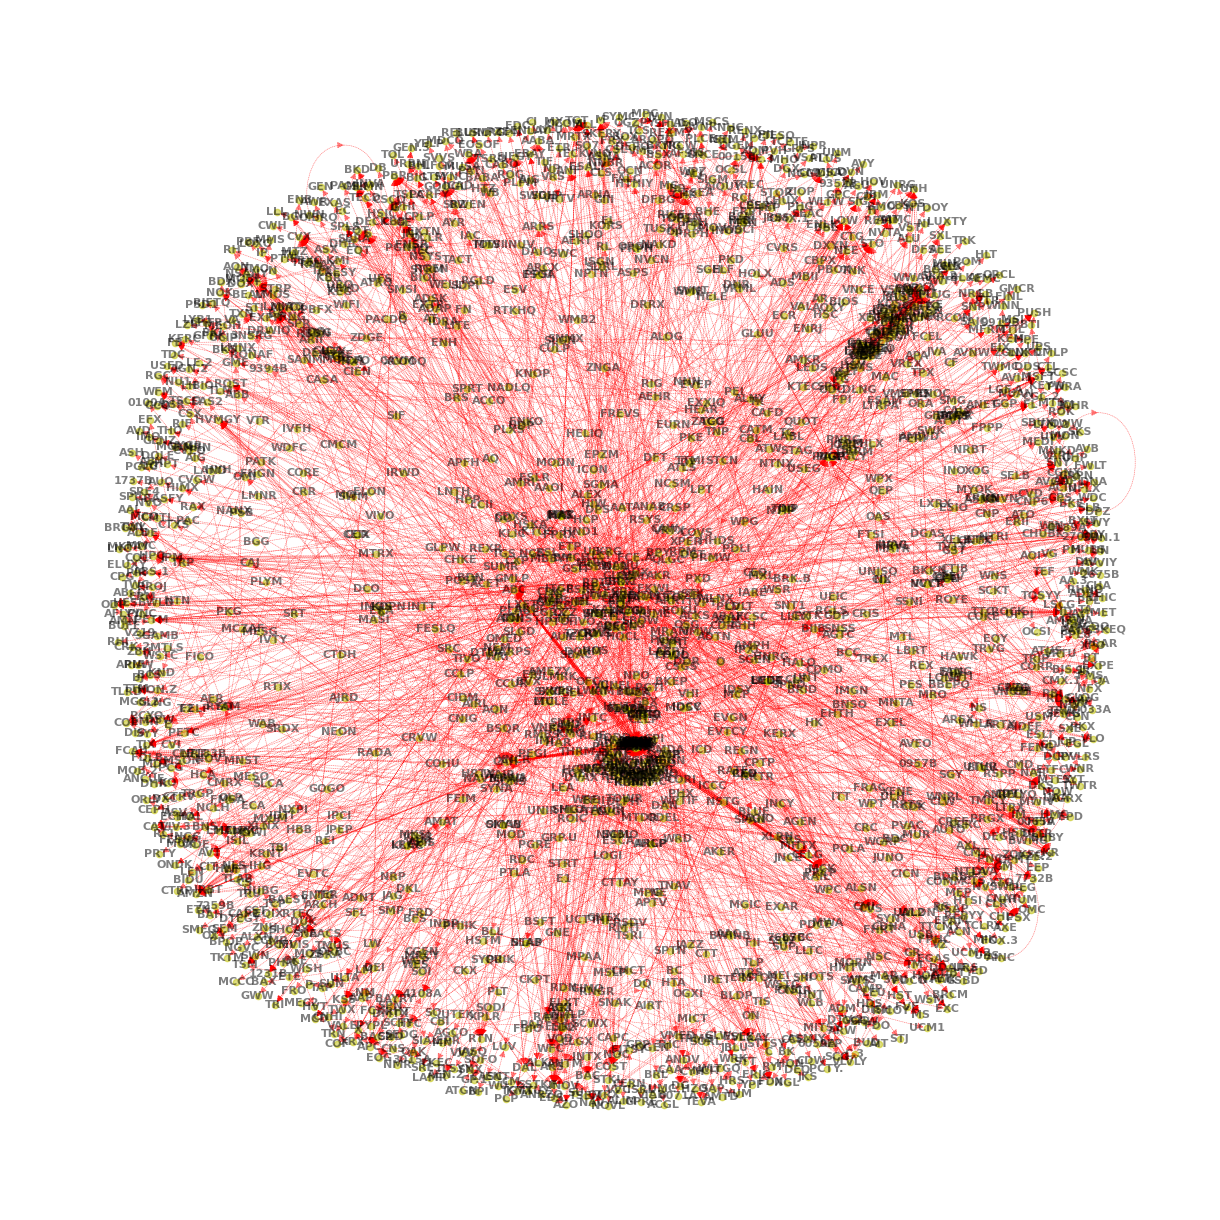

In [6]:
pos = graph_draw(G,
                 figsize=(12, 12),
                 savefig=imgdir / 'graph.jpg',
                 font_color='k',
                 node_color='y')
plt.show()

In [7]:
# 3. Node properties
G.remove_edges_from(nx.selfloop_edges(G))  # remove self-loops, if any

# Nodes Centrality

- show top nodes' centrality properties

In [8]:
centrality = DataFrame.from_dict(nodes_centrality(G))
n = 5
for c in centrality.columns:
    df = centrality[[c]].sort_values(by=c, ascending=False)[:n]
    print(pd.concat((lookup[df.index].rename('name'), df), axis=1))

                             name  clustering
ODC          OIL DRI CORP AMERICA         0.5
FORM               FORMFACTOR INC         0.5
FVE   FIVE STAR SENIOR LIVING INC         0.5
MKC            MCCORMICK & CO INC         0.5
PTR             PETROCHINA CO LTD         0.5
                         name  in_degree
WMT               WALMART INC   0.062329
MCK             MCKESSON CORP   0.022963
RDS.A   ROYAL DUTCH SHELL PLC   0.022963
CAH       CARDINAL HEALTH INC   0.022417
ABC    AMERISOURCEBERGEN CORP   0.019683
                            name  out_degree
AKAM     AKAMAI TECHNOLOGIES INC    0.015856
DHX                DHI GROUP INC    0.013669
KRG      KITE REALTY GROUP TRUST    0.011482
NPO         ENPRO INDUSTRIES INC    0.011482
CBL   CBL & ASSOCIATES PPTYS INC    0.010935
                       name  eigenvector
ZIOP  ZIOPHARM ONCOLOGY INC     0.500000
XON           INTREXON CORP     0.500000
FCSC  FIBROCELL SCIENCE INC     0.500000
OGEN          ORAGENICS INC     0.500000
AET

## Longest path

## Ego graph

- induce ego-graph of max betweenness node and neighbors


In [9]:
c = 'betweenness'
center = centrality.index[np.argmax(centrality[c])]
all_neighbors = list(nx.all_neighbors(G, center))  # predecessors and successors
neighbors = list(nx.neighbors(G, center))          # successors only
ego = G.subgraph([center] + all_neighbors).copy()
graph_info(ego, fast=True)

{'weakly_connected': True,
 'weakly_connected_components': 1,
 'size_largest_weak_component': 39,
 'strongly_connected': False,
 'strongly_connected_components': 39,
 'size_largest_strong_component': 1,
 'directed': True,
 'weighted': False,
 'edges': 41,
 'nodes': 39,
 'selfloops': 0,
 'density': 0.02766531713900135}

{'SHPG': array([-0.25082933, -0.35567791]),
 'WBA': array([-1.        , -0.03256569]),
 'BMY': array([ 0.00178938, -0.52295215]),
 'LLY': array([0.43506672, 0.24086706]),
 'ACUR': array([0.17293448, 0.57909669]),
 'MRK': array([0.60701898, 0.30035638]),
 'VVUS': array([ 0.49540816, -0.40330805]),
 'PTX': array([-0.04990963,  0.67154546]),
 'IPXL': array([ 0.3459714 , -0.50353382]),
 'ENDP': array([ 0.08266948, -0.37185982]),
 'PFE': array([-0.14875308, -0.00745675]),
 'TLGT': array([ 0.69966816, -0.02100429]),
 'AMGN': array([-0.40817628,  0.61391159]),
 'ABBV': array([ 0.26554787, -0.32381893]),
 'BIIB': array([-0.60259212,  0.40572203]),
 'AMPH': array([-0.06136585, -0.24890341]),
 'AGN': array([-0.66651497,  0.13778222]),
 'ESRX': array([0.76898448, 0.56049694]),
 'PDLI': array([-0.39867019, -0.12518804]),
 'RHHBY': array([ 0.17165874, -0.51965105]),
 'SPPI': array([ 0.54197759, -0.11407883]),
 'KERX': array([0.60375536, 0.4485514 ]),
 'ANIP': array([-0.2840836 ,  0.50338873]),
 'LC

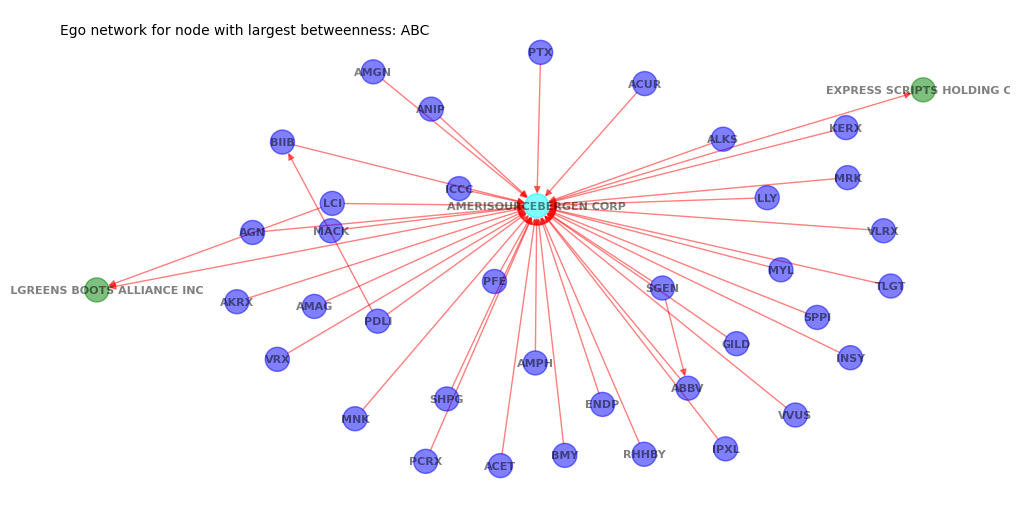

In [10]:
node_color = (dict.fromkeys(all_neighbors, 'b')
              | dict.fromkeys(neighbors, 'g')
              | {center: 'cyan'})

labels = ({ticker: ticker for ticker in ego.nodes}
          | {ticker: lookup[ticker] for ticker in [center] + neighbors})

graph_draw(ego,
           figsize=(10, 5),
           savefig=imgdir / f"{center},png",
           node_size=300,
           width=1,
           node_color=node_color,
           labels=labels,
           style='-',
           title=f"Ego network for node with largest {c}: {center}") 